# Tuning ECM Models with Online Estimation
This tutorial describes how to monitor battery health with online estimation 
if you already know an Equivalent Circuit Model (ECM) for its behavior.

## Load Example Data
We'll use the data from a simple battery model as a demonstration

In [1]:
from pathlib import Path
from shutil import copyfileobj
import requests

In [2]:
data_url = 'https://github.com/ROVI-org/battery-data-toolkit/raw/refs/heads/main/tests/files/example-data/single-resistor-complex-charge_from-discharged.hdf'
data_path = Path('files') / 'complex-cycle-data.hdf'

In [3]:
if not data_path.is_file():
    data_path.parent.mkdir(exist_ok=True)
    data_path.write_bytes(requests.get(data_url).content)

Load it as a battery-data-toolkit dataset object

In [4]:
from battdat.data import CellDataset
data = CellDataset.from_hdf(data_path)

/home/lward/miniconda3/envs/moirae/lib/python3.10/site-packages/battdat/data.py:57: UserWarning: Metadata was created in a different version of battdat. supplied=0.4.0, current=0.4.1.
  warnings.warn(f'Metadata was created in a different version of battdat. supplied={supplied_version}, current={__version__}.')


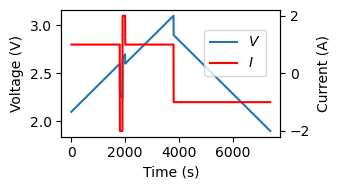

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(3.5, 2.))

raw_data = data.raw_data
ax.plot(raw_data['test_time'], raw_data['voltage'], label='$V$')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

ax2 = ax.twinx()
ax2.plot(raw_data['test_time'], raw_data['current'], color='red', label='$I$')
ax2.set_ylabel('Current (A)')

fig.legend(loc=(0.6, 0.6))
fig.tight_layout()

## Recreate the ECM Parameters with Moirae
Moirae includes a Python implementation of a Thevenin ECM.

Define the parameters for the ECM model as [Moirae-compatible Health parameter objects](../system-models.html#health-parameters)

All components of the model will eventually be combined to form a `ECMASOH` object,
and we'll only show the basic ones here (OCV, capacity, serial resistance)

In [6]:
from moirae.models.ecm import ECMASOH
for name, field in ECMASOH.model_fields.items():
    if name != "updatable":
        print(name, field.description)

q_t Maximum theoretical discharge capacity (Qt).
ce Coulombic efficiency (CE)
ocv Open Circuit Voltage (OCV)
r0 Series Resistance (R0)
c0 Series Capacitance (C0)
rc_elements Tuple of RC components
h0 Hysteresis component


The OCV is described using SOC-dependent variable defined using interpolation points.
Interpolation points are assumed to be evenly-spaced across [0, 1]
and the values at each point are defined as "base values"

In [7]:
from moirae.models.ecm.components import OpenCircuitVoltage, ReferenceOCV
ocv = OpenCircuitVoltage(
    ocv_ref=ReferenceOCV(base_values=[2, 3.])
)

Text(0, 0.5, 'V')

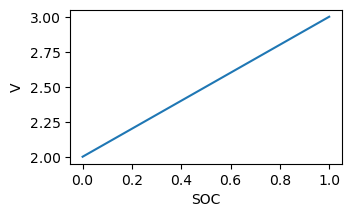

In [8]:
import numpy as np
fig, ax = plt.subplots(figsize=(3.5, 2.))

soc = np.linspace(0., 1, 32)[None, :]
v = ocv(soc)
ax.plot(soc.flatten(), v.flatten())

ax.set_xlabel('SOC')
ax.set_ylabel('V')

The resistance can be dependent on both SOC and temperature, but we'll choose to make it insensitive to both
by defining only a single interpolation point.

In [9]:
from moirae.models.ecm.components import Resistance
r0 = Resistance(base_values=[0.080])

Text(0, 0.5, 'R (m$\\Omega$)')

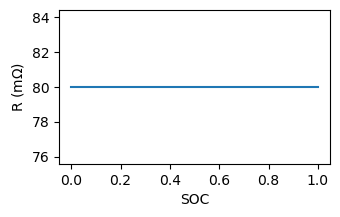

In [10]:
import numpy as np
fig, ax = plt.subplots(figsize=(3.5, 2.))

soc = np.linspace(0., 1, 32)[None, :]
r = r0.get_value(soc)
ax.plot(soc.flatten(), r.flatten() * 1000)

ax.set_xlabel('SOC')
ax.set_ylabel('R (m$\\Omega$)')

Capacity is defined as a "max theoretical capacity," which allows for capacity to change with parameters such as temperature

In [11]:
from moirae.models.ecm.components import MaxTheoreticalCapacity
q_t = MaxTheoreticalCapacity(base_values=1.)

Finally, combine them together

In [12]:
asoh = ECMASOH(
    q_t=q_t,
    ocv=ocv,
    r0=r0,
)

We're now ready to fit the parameters

## Run the model
Let's start by running the model using the same input currents as provided in the data.
Moirae provides a simple interface to running a model given input data from a battery-data-toolkit BatteryDataset.

The first step is to make an interface to running the ECM.

In [13]:
from moirae.models.ecm import EquivalentCircuitModel
model = EquivalentCircuitModel()

We then create a "transient state" which defines the initial state of charge of the system.

In [14]:
from moirae.models.ecm.transient import ECMTransientVector
state = ECMTransientVector.from_asoh(asoh)
state

ECMTransientVector(soc=array([[0.]]), q0=None, i_rc=array([], shape=(1, 0), dtype=float64), hyst=array([[0.]]))

Then run it

In [15]:
from moirae.interface import run_model
output = run_model(
    model=model,
    dataset=data,
    asoh=asoh,
    state_0=state
)

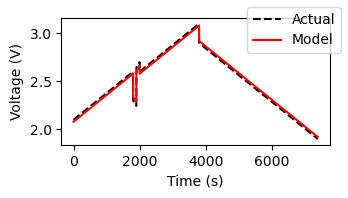

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(raw_data['test_time'], raw_data['voltage'], 'k--', label='Actual')
ax.plot(raw_data['test_time'], output['terminal_voltage'], color='r', label='Model')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

fig.legend()
fig.tight_layout()

The result is close, but not quite the on point. We might have an issue with the resistance.

## Fitting ASOH with Online State Estimation
Online state estimation works by adjusting the estimates for the state of a dynamic system based on 
discrepancies between values predicted by a model for that system and what is actually measured.
The "online" portion in the algorithm refers to it why it works: gradually adjusting with every new measurement.

The ['online estimator' classes](../estimators/index.html#online-estimators) in Moirae define 
online estimation algorithms.
For simplicity, we'll make one which estimates the resistance value and the SOC.

Start by marking the interpolation point for serial resitance ("r0.base_values") as updatable.

In [17]:
asoh.mark_updatable('r0.base_values')
asoh.updatable_names

('r0.base_values',)

Then define uncertainties in the transient state (SOC and hysteresis values)
and the resistance. Each are expressed using covariance matrices.

In [18]:
asoh_covar = np.array([[0.001]])
tran_covar = np.diag([0.0001, 1e-7])

The state estimator requires estimates for the noise in the model and measurement.
We'll make them all rather small

In [19]:
voltage_err = 1.0e-03  # mV voltage error
noise_sensor = ((voltage_err / 2) ** 2) * np.eye(1)
noise_asoh = 1.0e-10 * np.eye(asoh_covar.shape[0])
noise_tran = 1.0e-08 * np.eye(2)

In [20]:
from moirae.estimators.online.joint import JointEstimator
from moirae.models.ecm.ins_outs import ECMInput
estimator = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=EquivalentCircuitModel(),
    initial_asoh=asoh.model_copy(deep=True),
    initial_inputs=ECMInput(
        time=0,
        current=0,
    ),
    initial_transients=state.model_copy(deep=True),
    covariance_asoh=asoh_covar,
    covariance_transient=tran_covar,
    transient_covariance_process_noise=noise_tran,
    asoh_covariance_process_noise=noise_asoh,
    covariance_sensor_noise=noise_sensor
)

Use the estimator with a BatteryDataset through Moirae's `run_online_estimate` interface

In [21]:
from moirae.interface import run_online_estimate
estimates, estimator = run_online_estimate(
    dataset=data,
    estimator=estimator,
)

The interface returns the estimator after running over the data

In [22]:
est_state, est_asoh = estimator.get_estimated_state()

In [23]:
print(f'Original r0: {asoh.r0.base_values.item() * 1000:.1f} mOhm\n'
      f'Fit r0: {est_asoh.r0.base_values.item() * 1000:.1f} mOhm')

Original r0: 80.0 mOhm
Fit r0: 100.6 mOhm


Note how the estimated resistance has changed from 80 to 100 m&Omega; after running the filter.

The other output is a dataframe showing how the estimates for resistance and the other variables
changed over time.

In [24]:
estimates.head()

,soc,hyst,r0.base_values,soc_std,hyst_std,r0.base_values_std,terminal_voltage,terminal_voltage_std
0,0.001868,0.000002,0.098681,0.000091,1.099890e-07,0.000091,2.080000,1.100370e-03
1,0.002424,0.000002,0.098683,0.000091,1.139484e-07,0.000091,2.101106,5.201244e-07
2,0.002980,0.000002,0.098683,0.000091,1.175263e-07,0.000091,2.101664,3.998351e-07
3,0.003535,0.000002,0.098684,0.000091,1.207015e-07,0.000091,2.102221,3.635216e-07
4,0.004091,0.000002,0.098684,0.000091,1.234826e-07,0.000091,2.102777,3.477670e-07


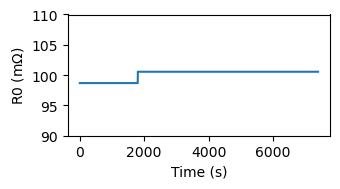

In [25]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(raw_data['test_time'].iloc[1:], estimates['r0.base_values'] * 1000)

ax.set_ylim([90, 110])

ax.set_xlabel('Time (s)')
ax.set_ylabel('R0 (m$\\Omega$)')

fig.tight_layout()
# TODO (wardlt): I'm not sure what's going on with the last point

Note how the resistance is corrected very quickly and becomes exact around 1800 seconds, which corresponds to the current pulse.
The agreement both shows how online estimators can quickly find the value of parameter values and, importantly,
that their accuracy is contingent on whether the data provided allows changes in the model parameters to have a large effect.